## Simple Pixel Level Decorrelation (PLD)

This notebook was written by John during the workshop conducted by R. Luger as part of the Kepler conference held in June 2017.

This notebook demonstrates how to download lightcurve data from MAST using everest-pipeline and implement basic PLD technique utilizing time series from 35 individual pixels. This technique 

In [1]:
import everest
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
epic = 201367065
star = everest.Everest(epic)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201367065.


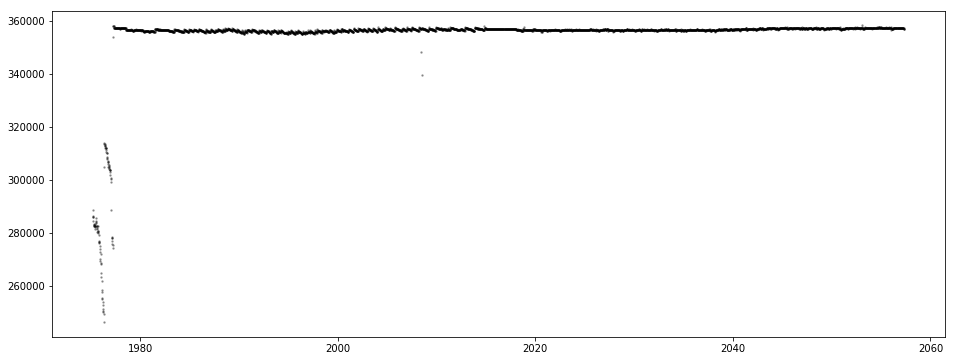

In [6]:
fig = pl.figure(figsize=(16,6))
pl.plot(star.time, star.fraw, 'k.', alpha=0.3, ms=3)

there are plenty of outliers, let's zoom in

(354000, 359000)

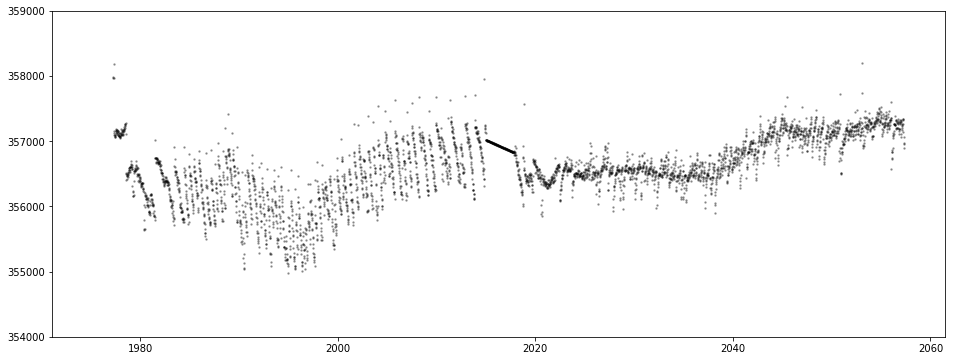

In [7]:
fig = pl.figure(figsize=(16,6))
pl.plot(star.time, star.fraw, 'k.', alpha=0.3, ms=3)
pl.ylim(354000,359000)

Now, let's trim the data as displayed above

In [10]:
#vertical cut
cut = np.where(star.fraw < 355000)
time = np.delete(star.time, cut)
#flux per pixel
fpix = np.delete(star.fpix, cut, axis=0)
ntime, npix = fpix.shape
ntime, npix

(3917, 35)

There are 35 pixels each is a time series with 3917 datapoints. Let's plot them.

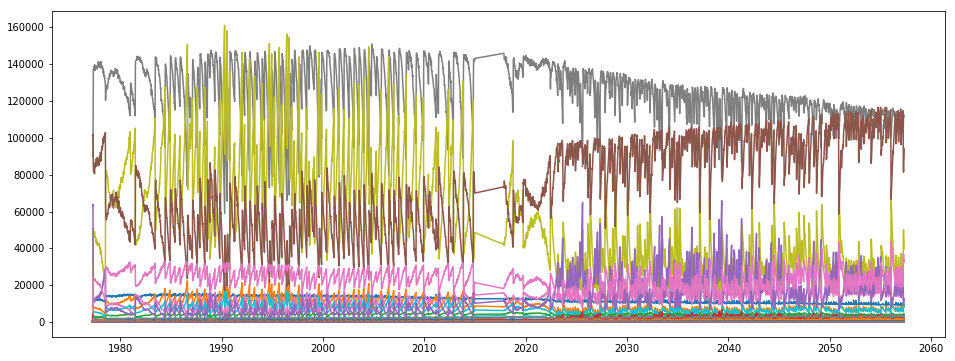

In [11]:
fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(time, fpix[:,n])

Similar to doing aperture photometry, sum the point-wise (at each time interval) values resembling the total flux and plot it.

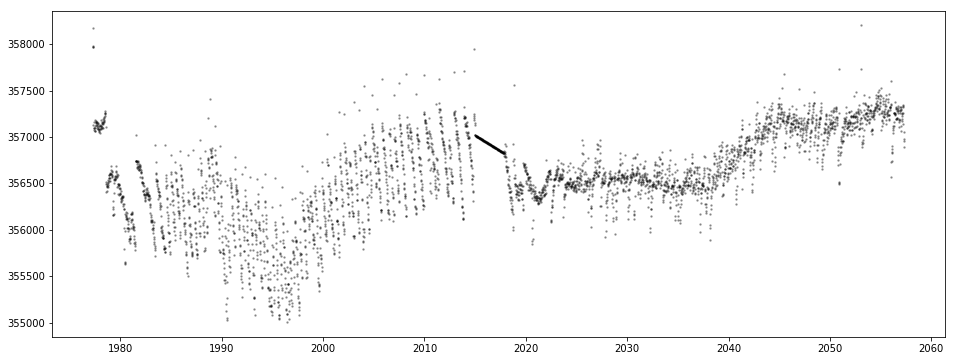

In [12]:
total_flux = np.sum(fpix, axis=1).reshape(-1,1)
fig = pl.figure(figsize=(16,6))
pl.plot(time, total_flux, 'k.', alpha=0.3, ms=3)

Normalize each pixel time series with the total flux containing the transit, variability, systematics, etc.

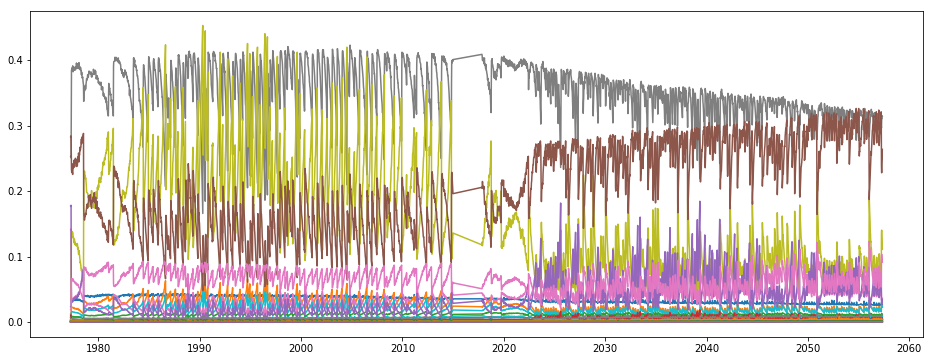

In [13]:
X = fpix / total_flux
fig = pl.figure(figsize=(16,6))
for n in range(npix):
    pl.plot(time, X[:,n])

In [15]:
X.shape

(3917, 35)

Compute the weights of detrending vector given each "normalized pixel light curve," X.
Remember in linear algebra, the matrix should be square to be invertible:
\begin{align}
y=&X \cdot w \\
y\cdot X^T=&X \cdot w \cdot X^T \; (\rm{multiply \;} X^T) \\
(X \cdot X^T)^{-1}y\cdot X^T=& w \; (\rm{solve \; for \;} w)
\end{align}

In [38]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

Contruct a systematics model by combining the normalized pixel light curve and weights. Then detrend the total flux by subtracting the systematics model. Use std() as a measure of scatter, for comparison later.

In [40]:
model = np.dot(X, w)
detrended_flux = total_flux - model
# preserve the original flux value
detrended_flux += np.nanmedian(total_flux)

219.955189079


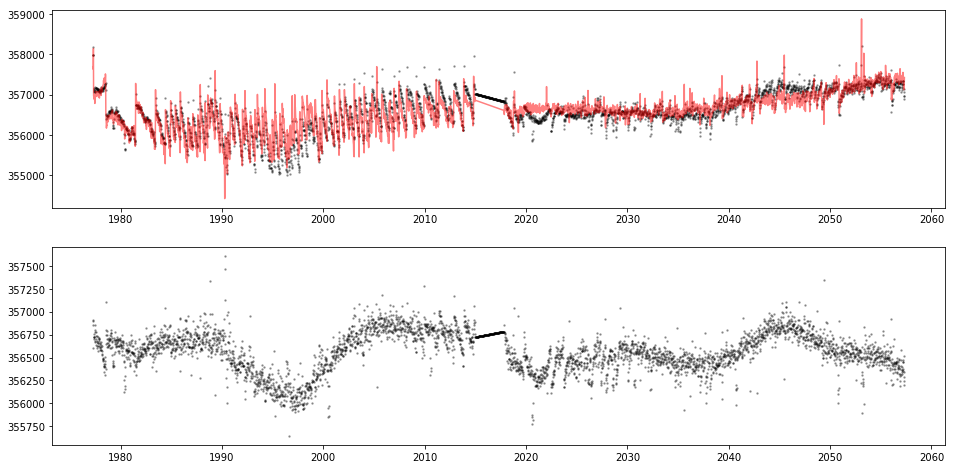

In [41]:
fig, axs = pl.subplots(2, figsize=(16,8))
#raw data
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
#model
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

In [ ]:
print detrended_flux.std()

but can be improved by modeling stellar variability...
==

In [8]:
np.hstack?

In [42]:
X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))
X.shape

(3917, 85)

The design matrix, X, now has additional columns (35+50=85) besides the pixel light curves (for a 49th order polynomial!). Let's solve for the weights again.

86.2995442478


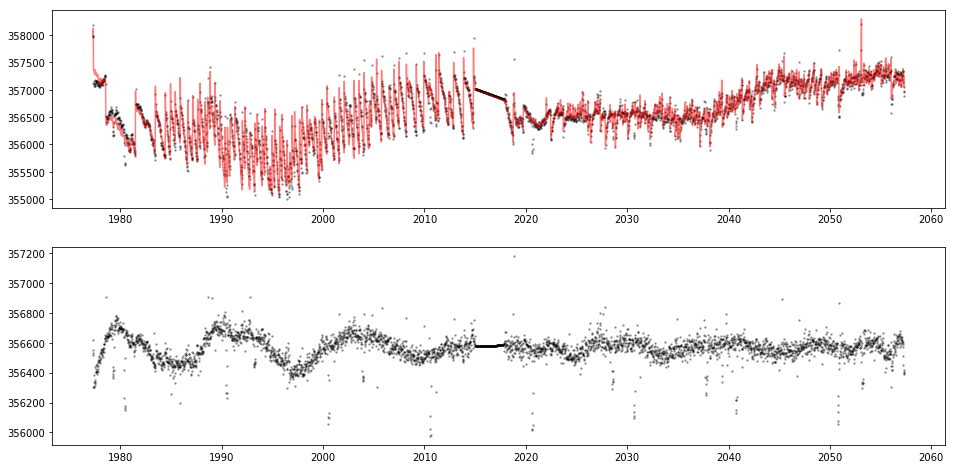

In [43]:
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

model = np.dot(X, w)
detrended_flux = total_flux - model
detrended_flux += np.nanmedian(total_flux)

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

In [ ]:
print detrended_flux.std()

The individual transit are even visible already!

much better! now let's try 2nd order PLD...
==

75.9135038288


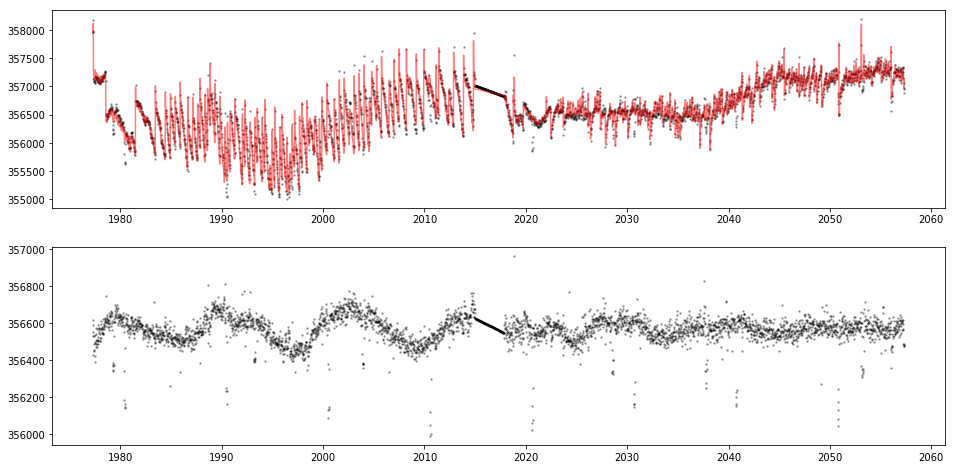

In [44]:
X = np.c_[fpix, fpix**2] / total_flux

X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))

w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

model = np.dot(X, w)
detrended_flux = total_flux - model
detrended_flux += np.nanmedian(total_flux)
print detrended_flux.std()

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

looks better! how about 3rd order?
==

62.0352105563


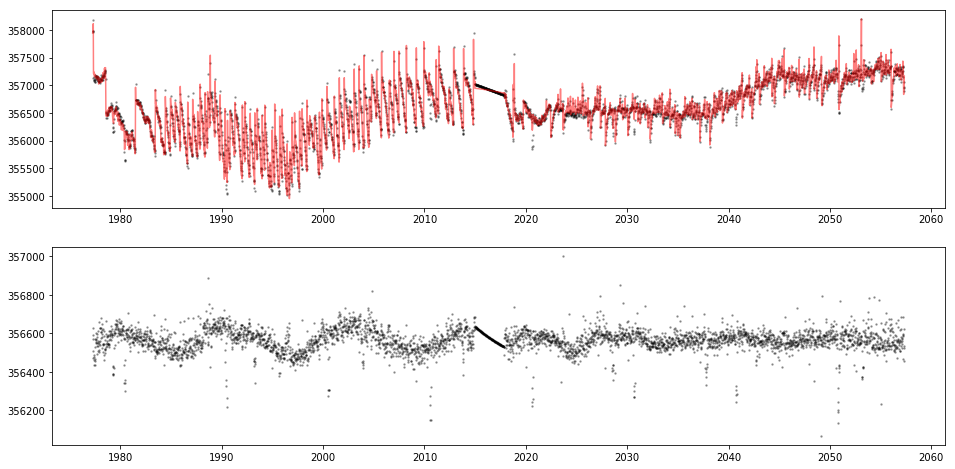

In [45]:
X = np.c_[fpix, fpix**2, fpix**3] / total_flux

# X = np.hstack((X, np.array([np.linspace(0,2,ntime)**n for n in range(50)]).T))
X = np.hstack((X, np.vander(np.linspace(0,2,ntime),50))) # same as above!

w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, total_flux))

model = np.dot(X, w)
detrended_flux = total_flux - model
detrended_flux += np.nanmedian(total_flux)
print detrended_flux.std()

fig, axs = pl.subplots(2, figsize=(16,8))
axs[0].plot(time, total_flux, 'k.', alpha=0.3, ms=3)
axs[0].plot(time, model, 'r-', alpha=0.5)
axs[1].plot(time, detrended_flux, 'k.', alpha=0.3, ms=3)

Finally, compare result using everest-pipeline api which implements a Gaussian Process model rather than polynomial fittting shown above.

INFO  [everest.user.plot()]: Plotting the light curve...


/Users/jhl/miniconda2/envs/py2k/lib/python2.7/site-packages/everest/user.py:628: RuntimeWarning: invalid value encountered in less
  for i in np.where(flux < ylim[0])[0]:
/Users/jhl/miniconda2/envs/py2k/lib/python2.7/site-packages/everest/user.py:644: RuntimeWarning: invalid value encountered in greater
  for i in np.where(flux > ylim[1])[0]:


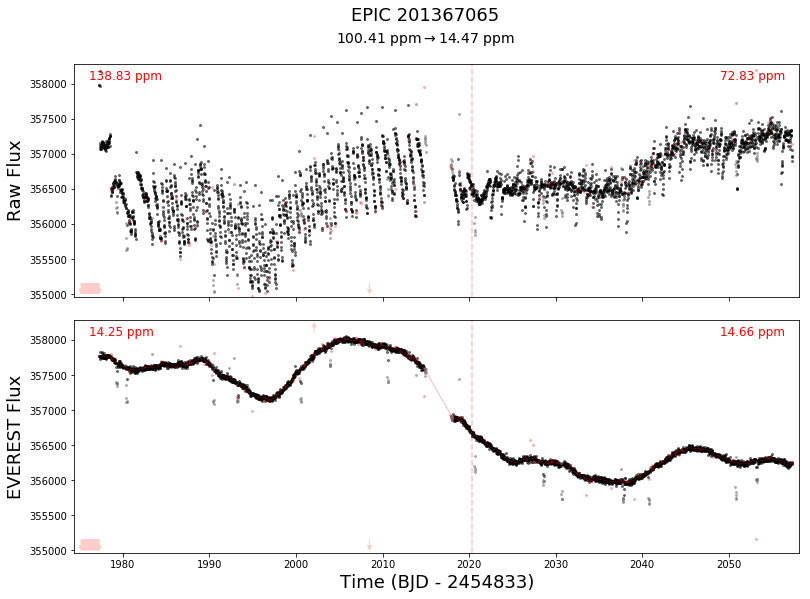

In [29]:
star.plot()